In [98]:
# Core data wrangling
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", None)

# Visualisation
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8-darkgrid")
sns.set_palette("mako")
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Time-series
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

# Prophet (Meta)
from prophet import Prophet

# ML / Evaluation
from sklearn.metrics import mean_absolute_error, mean_squared_error,r2_score
from sklearn.model_selection import TimeSeriesSplit,train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor

# Utilities
import warnings, os, datetime
warnings.filterwarnings("ignore")
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Cell 3 – Load Raw Data

In [48]:
RAW = "silver_prices_data.csv"
FUT = "silver_price_forecast_2026.csv"

df = pd.read_csv(RAW, parse_dates=["Date"])
df = df.sort_values("Date").reset_index(drop=True)

print("Shape:", df.shape)
df.head()

Shape: (2513, 7)


,Date,Price,Close,High,Low,Open,Volume
0,2016-01-19,14.110,14.110,14.065,14.065,3,NaN
1,2016-01-20,14.147,14.147,14.147,14.147,1,NaN
2,2016-01-21,14.083,14.083,14.083,14.083,2,NaN
3,2016-01-22,14.043,14.290,14.043,14.290,7,NaN
4,2016-01-25,14.240,14.240,14.095,14.095,8,NaN


# Cell 4 – Quick Info & Missing Audit

In [49]:
display(df.info())
display(df.isna().sum())

# Quick stats
display(df.describe().T)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2513 entries, 0 to 2512
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    2513 non-null   datetime64[ns]
 1   Price   2513 non-null   float64       
 2   Close   2513 non-null   float64       
 3   High    2513 non-null   float64       
 4   Low     2513 non-null   float64       
 5   Open    2513 non-null   int64         
 6   Volume  0 non-null      float64       
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 137.6 KB


None

Date         0
Price        0
Close        0
High         0
Low          0
Open         0
Volume    2513
dtype: int64

,count,mean,min,25%,50%,75%,max,std
Date,2513,2021-01-16 19:25:31.396737024,2016-01-19 00:00:00,2018-07-20 00:00:00,2021-01-19 00:00:00,2023-07-19 00:00:00,2026-01-15 00:00:00,NaN
Price,2513.0,22.810332,11.735,16.834,21.402,25.514999,91.875999,8.847649
Close,2513.0,22.979758,12.205,16.91,21.59,25.719999,93.0,8.99884
High,2513.0,22.646283,11.735,16.764999,21.065001,25.275,88.705002,8.669933
Low,2513.0,22.812519,12.07,16.844999,21.33,25.514999,90.824997,8.816571
Open,2513.0,1777.77119,0.0,10.0,49.0,177.0,131415.0,10141.050503
Volume,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Cell 5 – Clean Column Names & Create Returns

In [50]:
df.columns = [c.strip().lower() for c in df.columns]
df["return"] = df["close"].pct_change()
df["log_close"] = np.log(df["close"])
df["year"]  = df["date"].dt.year
df["month"] = df["date"].dt.month
df.set_index("date", inplace=True)
df.head()

,price,close,high,low,open,volume,return,log_close,year,month
date,,,,,,,,,,
2016-01-19,14.110,14.110,14.065,14.065,3,NaN,NaN,2.646884,2016,1
2016-01-20,14.147,14.147,14.147,14.147,1,NaN,0.002622,2.649503,2016,1
2016-01-21,14.083,14.083,14.083,14.083,2,NaN,-0.004524,2.644968,2016,1
2016-01-22,14.043,14.290,14.043,14.290,7,NaN,0.014699,2.659560,2016,1
2016-01-25,14.240,14.240,14.095,14.095,8,NaN,-0.003499,2.656055,2016,1


# Cell 6 – EDA 1: Price Evolution (Static)

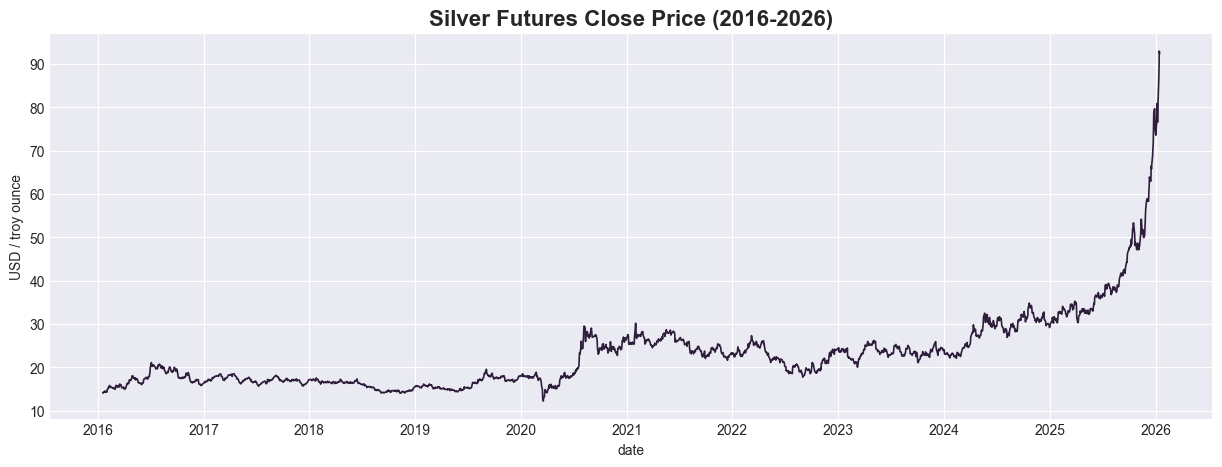

In [51]:
plt.figure(figsize=(15,5))
sns.lineplot(x=df.index, y=df["close"], linewidth=1.2)
plt.title("Silver Futures Close Price (2016-2026)", fontsize=16, weight="bold")
plt.ylabel("USD / troy ounce")
plt.show()

# Cell 7 – EDA 2: Volatility Regimes

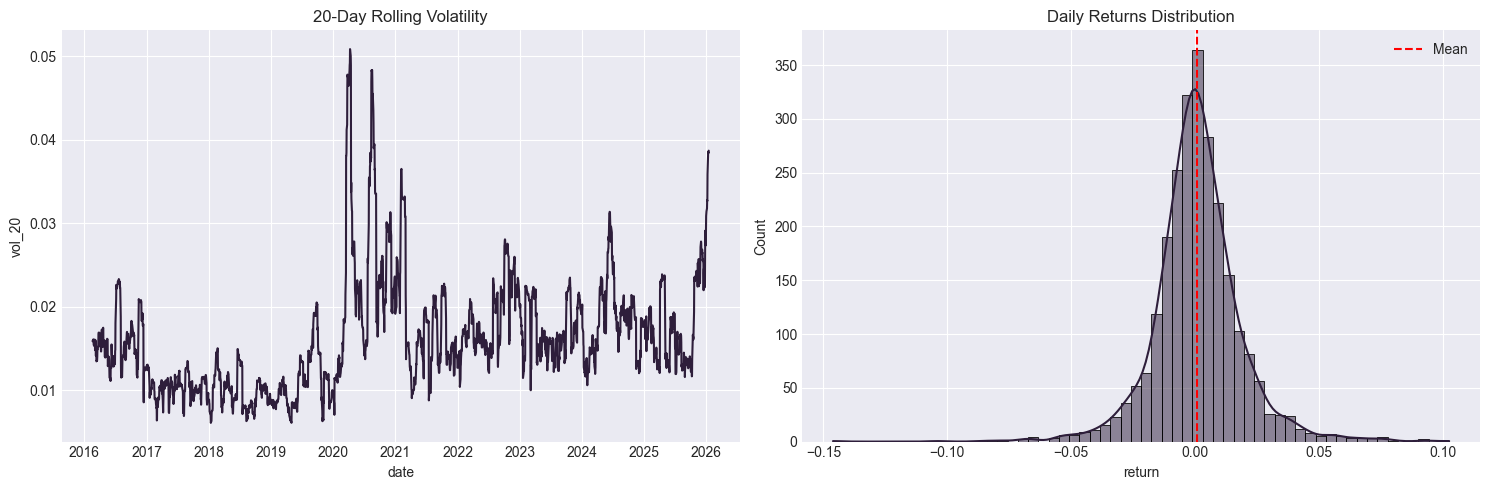

In [52]:
df["vol_20"] = df["return"].rolling(20).std()

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.lineplot(x=df.index, y=df["vol_20"])
plt.title("20-Day Rolling Volatility")
plt.subplot(1,2,2)
sns.histplot(df["return"].dropna(), kde=True, bins=60)
plt.title("Daily Returns Distribution")
plt.axvline(df["return"].mean(), color="red", ls="--", label="Mean")
plt.legend()
plt.tight_layout(); plt.show()

# Cell 8 – EDA 3: Seasonality Heat-map

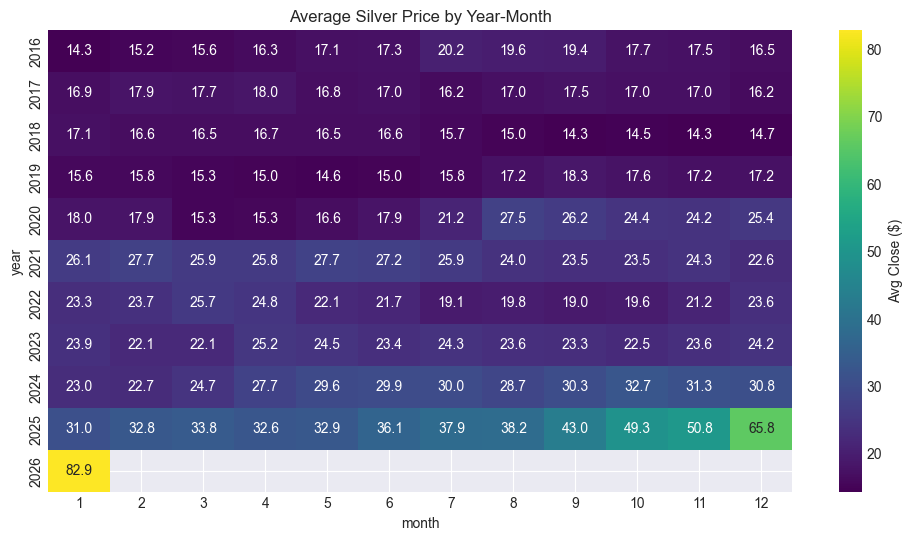

In [53]:
pivot = df.groupby(["year", "month"])["close"].mean().unstack()
plt.figure(figsize=(12,6))
sns.heatmap(pivot, cmap="viridis", annot=True, fmt=".1f", cbar_kws={"label":"Avg Close ($)"})
plt.title("Average Silver Price by Year-Month")
plt.show()

# Cell 9 – Time-Series Decomposition

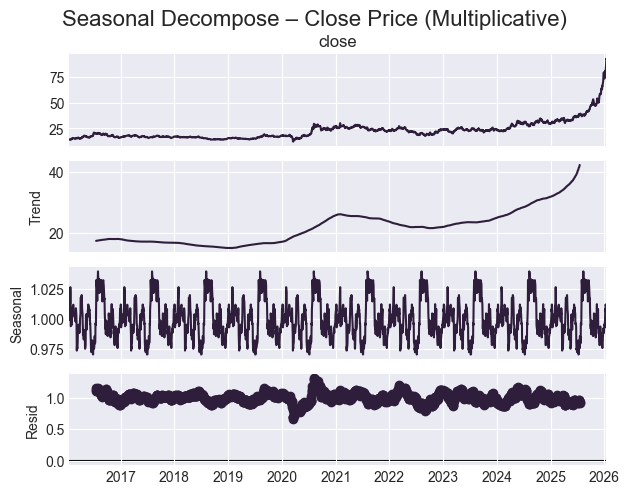

In [54]:
decomp = seasonal_decompose(df["close"].dropna(), model="multiplicative", period=252)
decomp.plot()
plt.suptitle("Seasonal Decompose – Close Price (Multiplicative)", y=1.02, fontsize=16)
plt.show()

# Cell 10 – Stationarity Test (ADF)

In [55]:
def adf_test(series, title=""):
    res = adfuller(series.dropna())
    print(f"{title}  ADF={res[0]:.4f}  p={res[1]:.4f}")
    return res[1] < 0.05

is_stationary = adf_test(df["close"], "Close")
adf_test(df["return"], "Returns")

Close  ADF=5.0970  p=1.0000
Returns  ADF=-45.5275  p=0.0000


True

In [64]:
# ----------------------------------------------------------
# 1.  SPLIT BEFORE FEATURES
# ----------------------------------------------------------
TEST_DAYS = 252
train_idx = df.index[:-TEST_DAYS]
test_idx  = df.index[-TEST_DAYS:]

train_raw = df.loc[train_idx].copy()
test_raw  = df.loc[test_idx].copy()

print("train_raw:", train_raw.shape, "test_raw:", test_raw.shape)

train_raw: (2261, 11) test_raw: (252, 11)


# Cell 11 – Feature Engineering Function

In [67]:
# Create Features
df['Daily_Return'] = df['close'].pct_change() * 100
df['Volatility_7d'] = df['Daily_Return'].rolling(7).std()
df['Volatility_30d'] = df['Daily_Return'].rolling(30).std()
df['Price_Range'] = df['high'] - df['low']
df['Month'] = df.index.month
df['DayOfWeek'] = df.index.dayofweek
df['Quarter'] = df.index.quarter

# Lag Features
for lag in [1, 7, 14, 30]:
    df[f'Price_Lag_{lag}'] = df['close'].shift(lag)

print('Feature Engineering Complete!')
print(f'Total Features: {len(df.columns)}')
df.head()

Feature Engineering Complete!
Total Features: 22


,price,close,high,low,open,volume,return,log_close,year,month,vol_20,Daily_Return,Volatility_7d,Volatility_30d,Price_Range,Month,DayOfWeek,Quarter,Price_Lag_1,Price_Lag_7,Price_Lag_14,Price_Lag_30
date,,,,,,,,,,,,,,,,,,,,,,
2016-01-19,14.110,14.110,14.065,14.065,3,NaN,NaN,2.646884,2016,1,NaN,NaN,NaN,NaN,0.000,1,1,1,NaN,NaN,NaN,NaN
2016-01-20,14.147,14.147,14.147,14.147,1,NaN,0.002622,2.649503,2016,1,NaN,0.262230,NaN,NaN,0.000,1,2,1,14.110,NaN,NaN,NaN
2016-01-21,14.083,14.083,14.083,14.083,2,NaN,-0.004524,2.644968,2016,1,NaN,-0.452394,NaN,NaN,0.000,1,3,1,14.147,NaN,NaN,NaN
2016-01-22,14.043,14.290,14.043,14.290,7,NaN,0.014699,2.659560,2016,1,NaN,1.469856,NaN,NaN,-0.247,1,4,1,14.083,NaN,NaN,NaN
2016-01-25,14.240,14.240,14.095,14.095,8,NaN,-0.003499,2.656055,2016,1,NaN,-0.349896,NaN,NaN,0.000,1,0,1,14.290,NaN,NaN,NaN


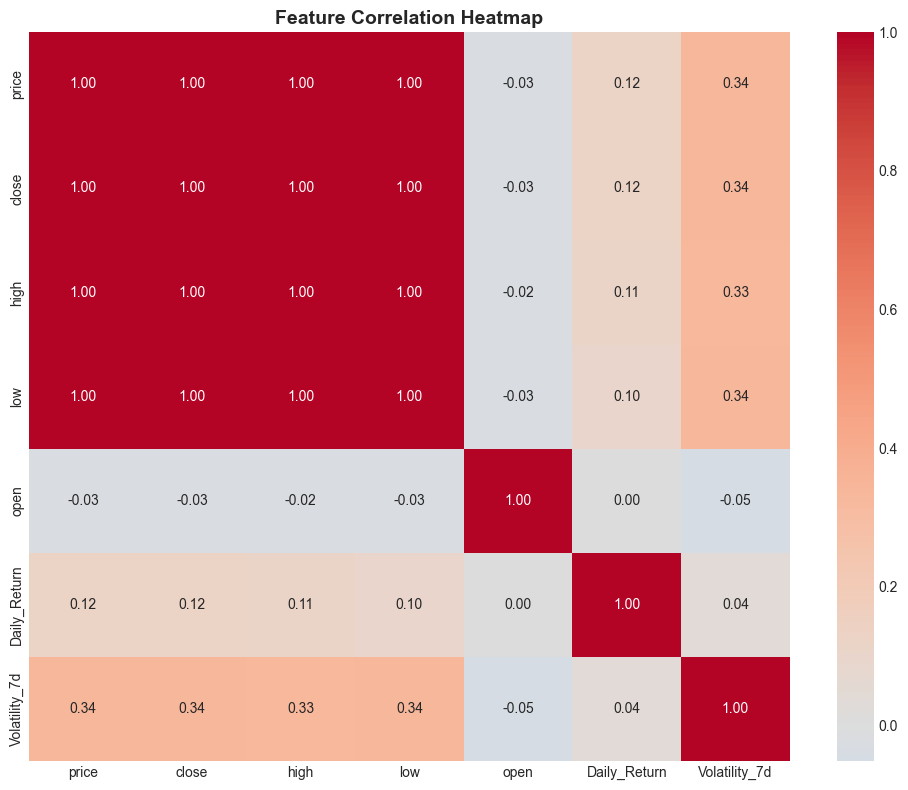

In [73]:
# Correlation Heatmap
corr_cols = ['price', 'close', 'high', 'low', 'open', 'Daily_Return', 'Volatility_7d']
corr_matrix = df[corr_cols].corr()

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f', ax=ax)
ax.set_title('Feature Correlation Heatmap', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Cell 13 – Prophet Baseline

In [74]:
# Use the original df for Prophet, as it is not empty
prop_df = df.reset_index()[["date", "close"]].rename(columns={"date": "ds", "close": "y"})
m = Prophet(daily_seasonality=False, yearly_seasonality=True, changepoint_prior_scale=0.05)
m.fit(prop_df)

future = m.make_future_dataframe(periods=test_size, freq="B")
forecast = m.predict(future)

# Get the last test_size predictions for RMSE calculation
prop_pred = forecast.iloc[-test_size:]["yhat"].values
# Use the last test_size actual closes from df for comparison
actual = df["close"].iloc[-test_size:].values
print("Prophet RMSE:", np.sqrt(mean_squared_error(actual, prop_pred)))

22:05:07 - cmdstanpy - INFO - Chain [1] start processing
22:05:08 - cmdstanpy - INFO - Chain [1] done processing


Prophet RMSE: 17.74491868783541


# Cell 14 – Prophet Plot

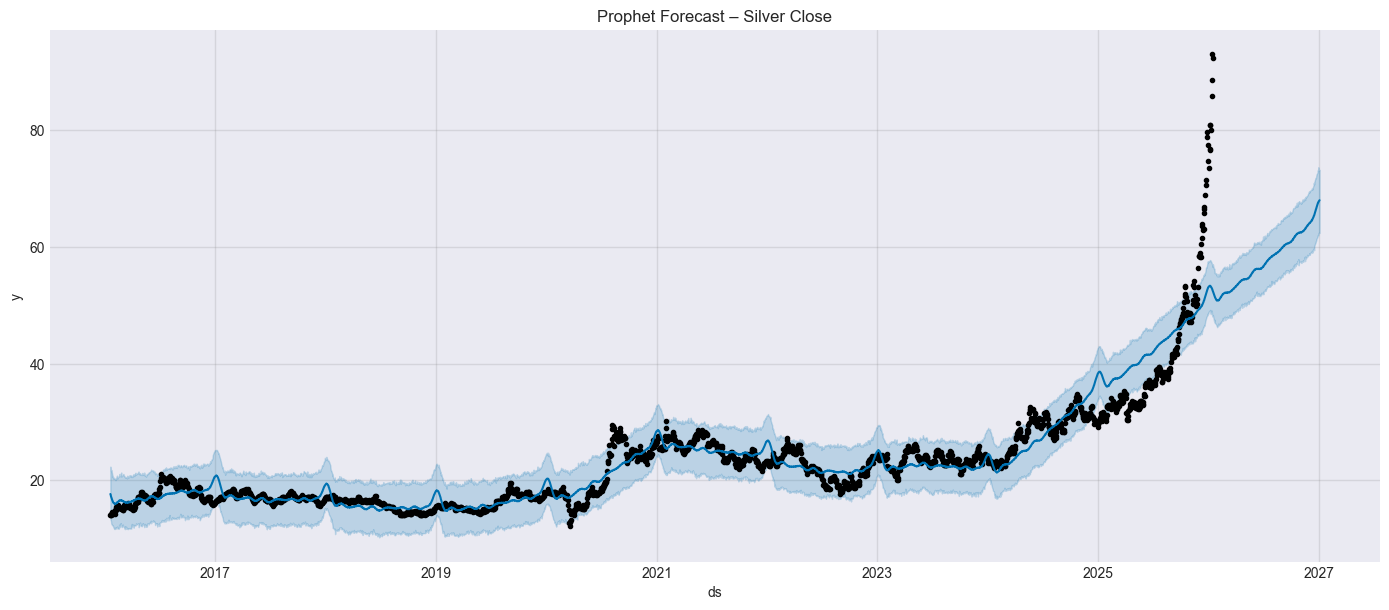

In [75]:
fig = m.plot(forecast, figsize=(14,6))
plt.title("Prophet Forecast – Silver Close")
plt.show()

In [79]:
# Prepare data for Prophet using the 'close' column (actual price)
prophet_df = df[['close']].reset_index()
prophet_df.columns = ['ds', 'y']
prophet_df = prophet_df.dropna()

# Train-test split
train_size = int(len(prophet_df) * 0.8)
train = prophet_df[:train_size]
test = prophet_df[train_size:]

print(f'Training samples: {len(train)}')
print(f'Testing samples: {len(test)}')

Training samples: 2010
Testing samples: 503


In [80]:
# Train Prophet Model
model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    changepoint_prior_scale=0.05,
    seasonality_prior_scale=10
)
model.fit(train)
print('Prophet model trained successfully!')

22:07:16 - cmdstanpy - INFO - Chain [1] start processing
22:07:18 - cmdstanpy - INFO - Chain [1] done processing


Prophet model trained successfully!


In [85]:
# Make predictions on test set
test_forecast = model.predict(test[['ds']])

# Calculate metrics
y_true = test['y'].values
y_pred = test_forecast['yhat'].values

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
r2 = r2_score(y_true, y_pred)

print('Prophet Model Evaluation Metrics:')
print(f'   RMSE: ${rmse:.2f}')
print(f'   MAE:  ${mae:.2f}')
print(f'   MAPE: {mape:.2f}%')
print(f'   R2:   {r2:.4f}')

Prophet Model Evaluation Metrics:
   RMSE: $14.60
   MAE:  $9.87
   MAPE: 23.08%
   R2:   -0.5538


22:10:21 - cmdstanpy - INFO - Chain [1] start processing
22:10:22 - cmdstanpy - INFO - Chain [1] done processing


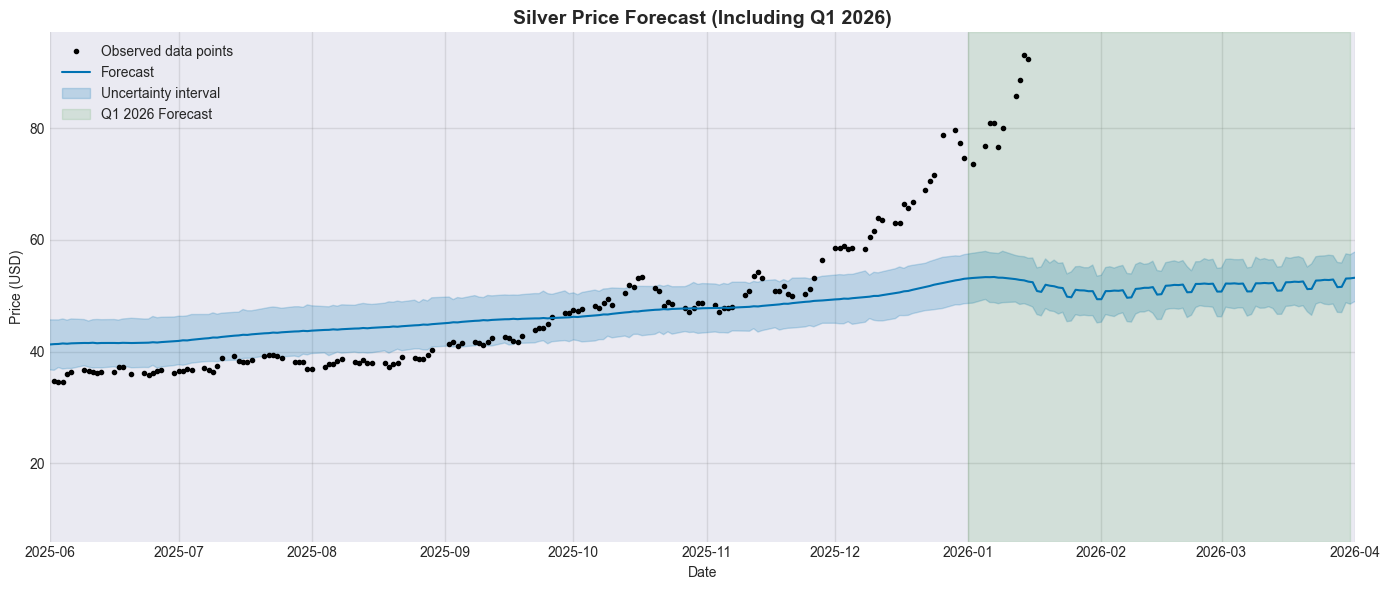

In [86]:
model_full = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    changepoint_prior_scale=0.05,
    seasonality_prior_scale=10
)
model_full.fit(prophet_df)

# Forecast for Q1 2026 (Jan, Feb, Mar)
future_dates = model_full.make_future_dataframe(periods=90, freq='D') 
forecast = model_full.predict(future_dates)
# Ensure ds is datetime
forecast['ds'] = pd.to_datetime(forecast['ds'])

# Filter for specific Q1 2026 range
start_date = pd.to_datetime('2026-01-01')
end_date = pd.to_datetime('2026-03-31')
forecast_q1_2026 = forecast[(forecast['ds'] >= start_date) & (forecast['ds'] <= end_date)]

# Plot forecast
fig = model_full.plot(forecast, figsize=(14, 6))
plt.title('Silver Price Forecast (Including Q1 2026)', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
# Highlight Q1 2026
plt.axvspan(start_date, end_date, color='green', alpha=0.1, label='Q1 2026 Forecast')
plt.legend()
plt.xlim(pd.to_datetime('2025-06-01'), pd.to_datetime('2026-04-01')) # Zoom in
plt.tight_layout()
plt.show()

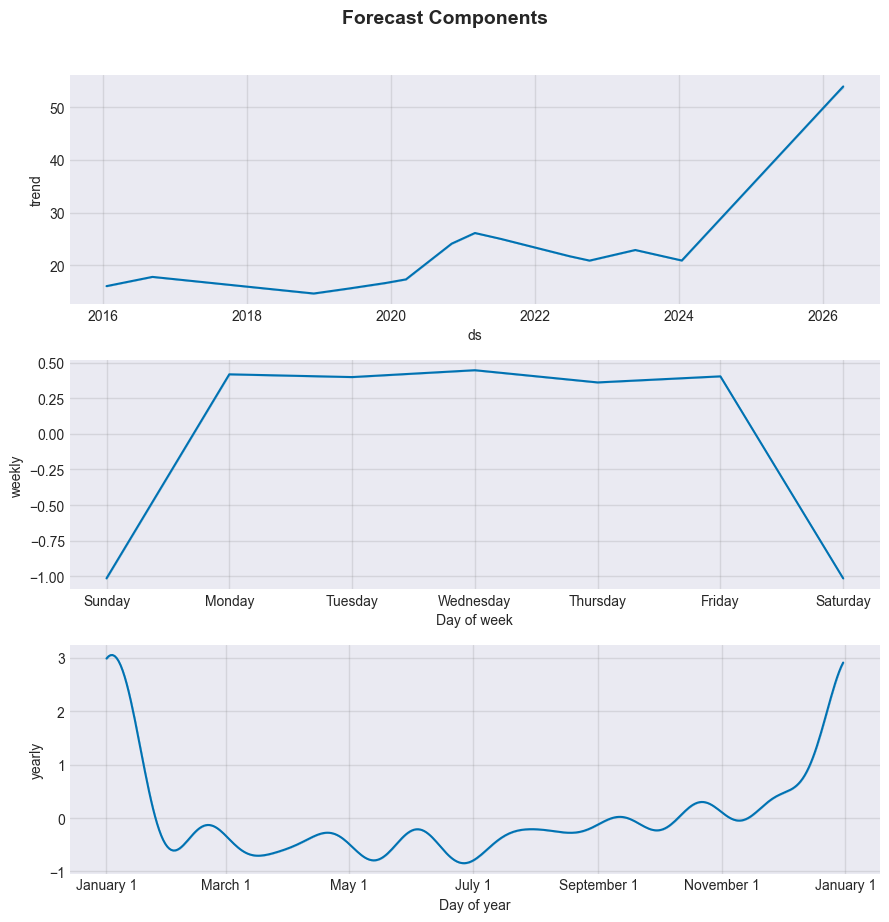

In [87]:
# Plot components
fig = model_full.plot_components(forecast)
plt.suptitle('Forecast Components', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

In [94]:
# Forecast Table for Q1 2026
forecast_export = forecast_q1_2026[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].copy()
forecast_export.columns = ['Date', 'Predicted_Price', 'Lower_Bound', 'Upper_Bound']
forecast_export = forecast_export.round(2)
print('Silver Price Forecast for Q1 2026 (Jan-Mar):')
print(f'Rows: {len(forecast_export)}')
forecast_export.head()

Silver Price Forecast for Q1 2026 (Jan-Mar):
Rows: 85


,Date,Predicted_Price,Lower_Bound,Upper_Bound
2503,2026-01-02,53.17,48.67,57.59
2504,2026-01-05,53.32,49.33,57.92
2505,2026-01-06,53.31,48.78,57.70
2506,2026-01-07,53.35,48.76,57.64
2507,2026-01-08,53.23,48.57,57.55


In [99]:
# Prepare data for Random Forest

# Create moving averages if not already present
df['ma_7'] = df['close'].rolling(window=7).mean()
df['ma_30'] = df['close'].rolling(window=30).mean()

features = ['close', 'high', 'low', 'open', 'ma_7', 'ma_30', 'Volatility_7d', 'Month', 'DayOfWeek', 'Price_Lag_1', 'Price_Lag_7']
df_ml = df[features].dropna().copy()
X = df_ml[features]
y = df_ml['close']

print(f'ML Dataset Shape: {df_ml.shape}')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Random Forest
rf_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
rf_model.fit(X_train_scaled, y_train)

# Predictions
rf_pred = rf_model.predict(X_test_scaled)

# Metrics
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_pred))
rf_mae = mean_absolute_error(y_test, rf_pred)
rf_r2 = r2_score(y_test, rf_pred)

print('Random Forest Model Evaluation:')
print(f'   RMSE: ${rf_rmse:.2f}')
print(f'   MAE:  ${rf_mae:.2f}')
print(f'   R2:   {rf_r2:.4f}')

ML Dataset Shape: (2484, 11)
Random Forest Model Evaluation:
   RMSE: $13.19
   MAE:  $7.10
   R2:   -0.2714


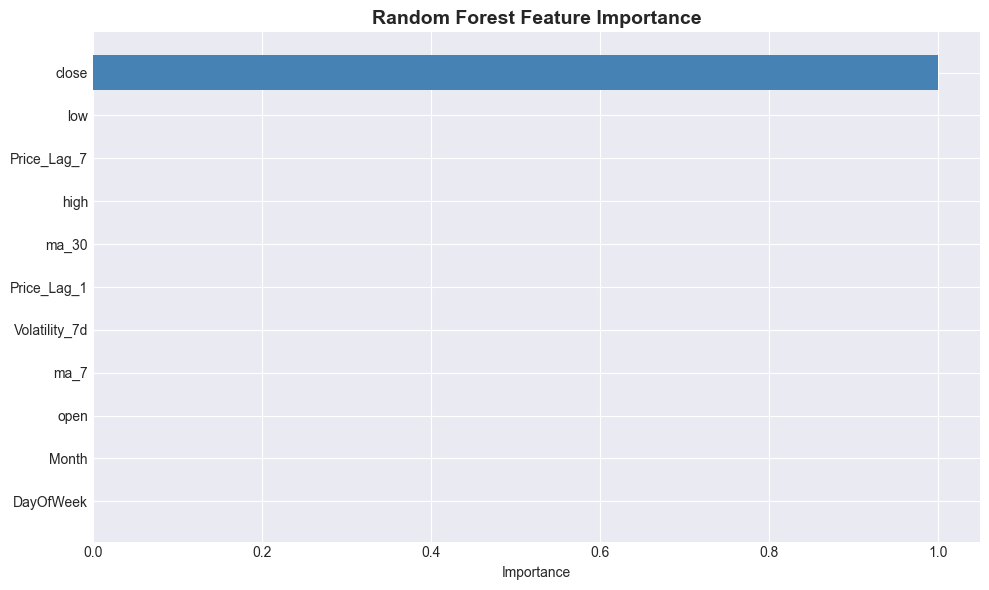

In [100]:
# Feature Importance
importance = pd.DataFrame({'Feature': features, 'Importance': rf_model.feature_importances_})
importance = importance.sort_values('Importance', ascending=True)

fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(importance['Feature'], importance['Importance'], color='steelblue')
ax.set_title('Random Forest Feature Importance', fontsize=14, fontweight='bold')
ax.set_xlabel('Importance')
plt.tight_layout()
plt.show()

In [101]:
# Model Comparison Table
comparison = pd.DataFrame({
    'Model': ['Prophet', 'Random Forest'],
    'RMSE ($)': [rmse, rf_rmse],
    'MAE ($)': [mae, rf_mae],
    'R2': [r2, rf_r2]
})
print('Model Comparison:')
comparison.round(4)

Model Comparison:


,Model,RMSE ($),MAE ($),R2
0,Prophet,14.6050,9.8726,-0.5538
1,Random Forest,13.1894,7.0972,-0.2714


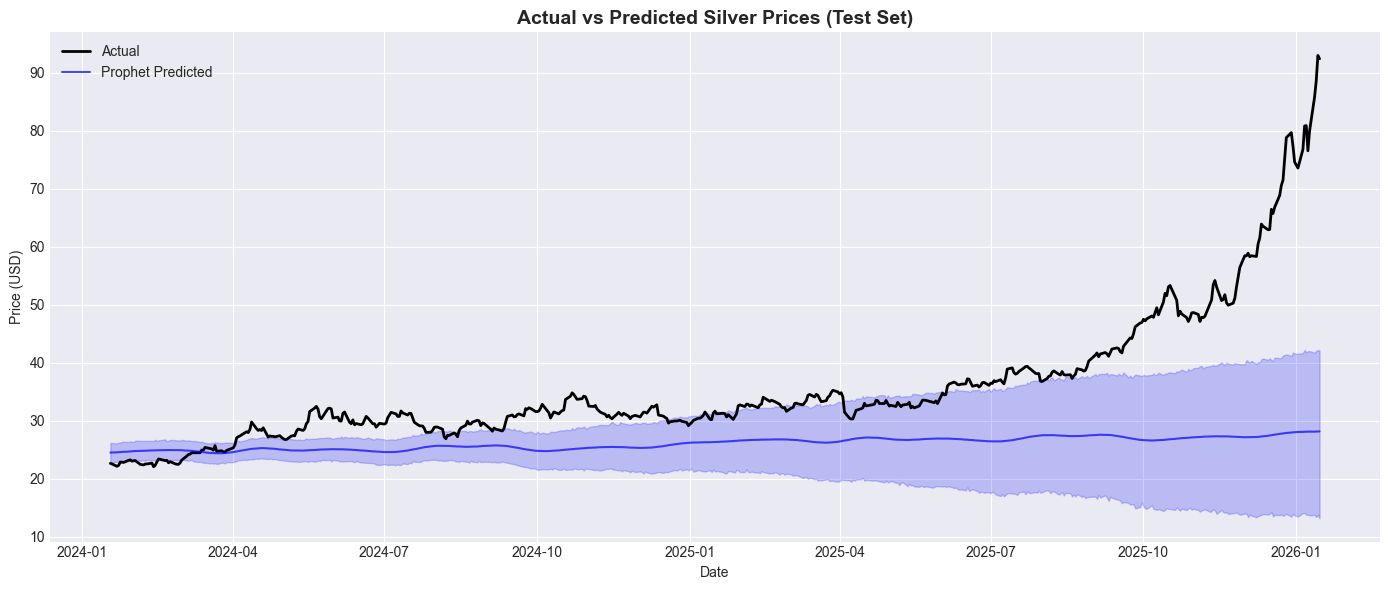

In [102]:
# Actual vs Predicted Plot
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(test['ds'].values, y_true, label='Actual', color='black', linewidth=2)
ax.plot(test['ds'].values, y_pred, label='Prophet Predicted', color='blue', alpha=0.7)
ax.fill_between(test['ds'].values, test_forecast['yhat_lower'].values, test_forecast['yhat_upper'].values, alpha=0.2, color='blue')
ax.set_title('Actual vs Predicted Silver Prices (Test Set)', fontsize=14, fontweight='bold')
ax.set_xlabel('Date')
ax.set_ylabel('Price (USD)')
ax.legend()
plt.tight_layout()
plt.show()

In [103]:
# Monthly Forecast Summary 2026
forecast_q1_2026['Month'] = forecast_q1_2026['ds'].dt.month_name()
monthly_forecast = forecast_q1_2026.groupby('Month')['yhat'].agg(['mean', 'min', 'max']).round(2)
monthly_forecast.columns = ['Avg Price', 'Min Price', 'Max Price']
monthly_forecast = monthly_forecast.reindex(['January', 'February', 'March'])
print('Monthly Price Forecast for Q1 2026:')
monthly_forecast

Monthly Price Forecast for Q1 2026:


,Avg Price,Min Price,Max Price
Month,,,
January,51.78,49.37,53.35
February,51.16,49.37,52.17
March,52.07,50.74,53.10


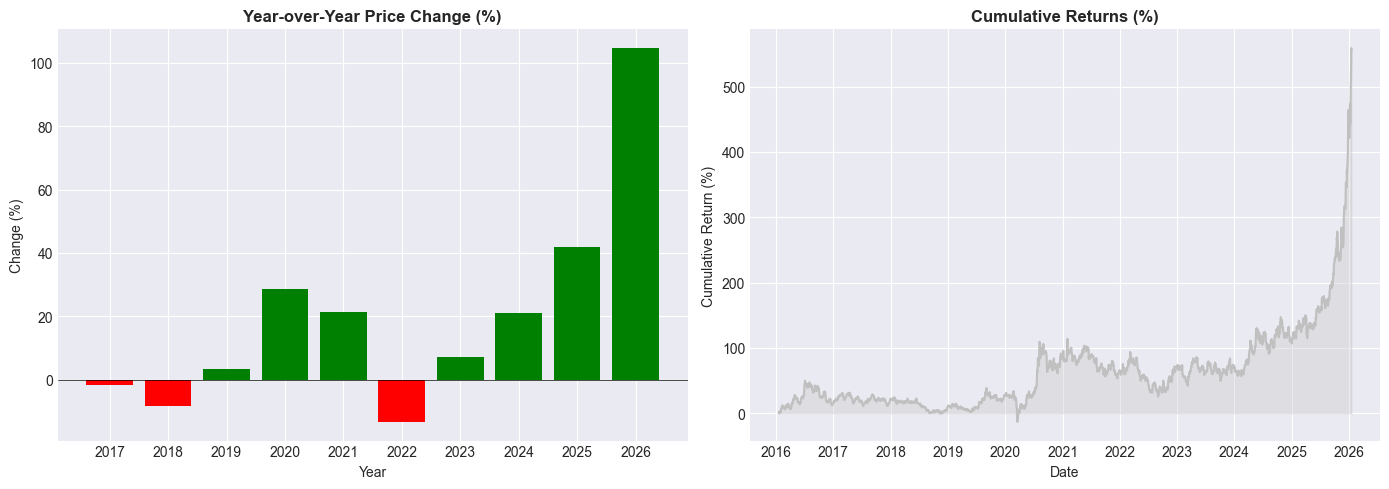

In [108]:
# Calculate YoY growth
yearly_avg = df.groupby('year')['close'].mean()
yoy_growth = yearly_avg.pct_change() * 100

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# YoY Growth
colors = ['green' if x > 0 else 'red' for x in yoy_growth.dropna()]
axes[0].bar(yoy_growth.dropna().index.astype(str), yoy_growth.dropna(), color=colors)
axes[0].set_title('Year-over-Year Price Change (%)', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Change (%)')
axes[0].axhline(y=0, color='black', linestyle='-', linewidth=0.5)

# Cumulative Returns
cumulative_returns = (1 + df['Daily_Return']/100).cumprod() - 1
axes[1].plot(df.index, cumulative_returns * 100, color='silver', linewidth=1.5)
axes[1].fill_between(df.index, cumulative_returns * 100, alpha=0.3, color='silver')
axes[1].set_title('Cumulative Returns (%)', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Cumulative Return (%)')

plt.tight_layout()
plt.show()

In [109]:
# Save forecast to CSV (Jan-Mar 2026 Only)
forecast_export.to_csv('silver_price_forecast_2026.csv', index=False)
print('Forecast saved to silver_price_forecast_2026.csv (Jan-Mar 2026 Only)')

Forecast saved to silver_price_forecast_2026.csv (Jan-Mar 2026 Only)
